In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import scipy as sp


In [3]:
# data_dir = Path(r'C:\Users\sebas\Documents\MATLAB\DataProCiencia\DeepLearning\raw')
# file_name = 'rf_qus_AC_INCrand_1'
data_dir = Path(r'C:\Users\smerino.C084288\Documents\Datasets\ACS\raw')
file_name = 'rf_qus_AC_BSC_INCrand_1.mat'
data_dict = sp.io.loadmat(str(data_dir / file_name))
data_dict.keys()
data_dict['alpha_mean']

array([[1.05, 0.71]])

In [4]:
x = data_dict['x'].squeeze()
z = data_dict['z'].squeeze()
rf = data_dict['rf']
alpha = data_dict['alpha_mean']

dx = x[1] - x[0]
x_offset = x[0]*100
dz = z[1] - z[0] # dz = 1/fs*c0/2
x = 100*x
z = 100*z

fs = data_dict['fs'].squeeze()
c0 = data_dict['sos_mean'].squeeze()


In [5]:
def get_Bmode(rf):
    Bmode = 20*np.log10(np.abs(sp.signal.hilbert(rf,axis=0)))
    Bmode = Bmode - np.max(Bmode)
    return Bmode

Bmode = get_Bmode(rf)

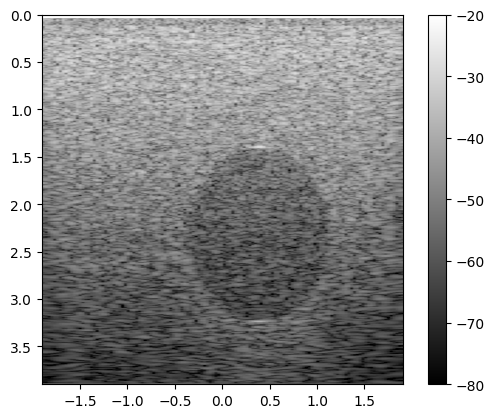

In [6]:
extent = (x[0], x[-1], z[-1], z[0])
plt.imshow(Bmode, cmap='gray', extent=extent)
plt.clim([-80,-20])
plt.colorbar()
plt.show()

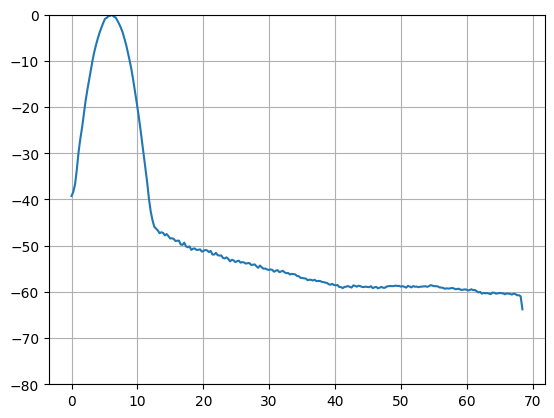

In [7]:
# spect = np.fft.fft(rf-np.mean(rf), axis=1)
# spect = np.mean(spect, axis=0)
f, spect = sp.signal.welch(rf, fs=fs, nperseg=512, nfft=512, axis=0, window=('tukey',0.25))
spect = np.mean(spect, axis=1)
spect = 10*np.log10(spect)
spect = spect - np.max(spect)
# print(spect.shape)

plt.plot(np.squeeze(f/1e6),spect)
# plt.xlim(0,15)
plt.ylim(-80,0)
plt.grid()
plt.show()

# wl = 2*c0/

### Parameters

In [8]:
blocksize = 8
freq_L = 2e6; freq_H = 10e6
freq_C = 6e6 
deltaF = 100e3
overlap_pc      = 0.8

In [9]:
# Wavelength size
c0 = 1540
wl = c0/freq_C
nFFT = np.round(fs/deltaF)

In [10]:
wz = round(blocksize*wl*(1-overlap_pc)/dz ); # Between windows
nz = 2*round(blocksize*wl/dz /2 ); # Window size


## Spectrogram of line

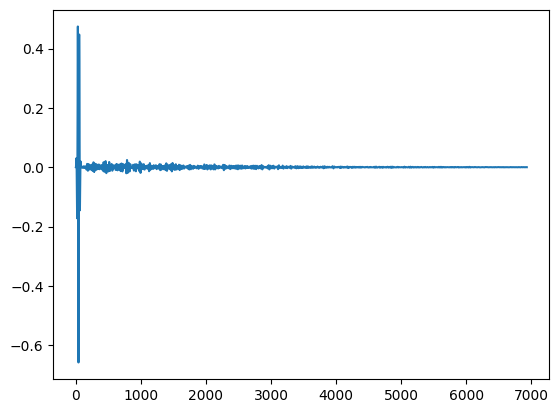

In [11]:
line = rf[:,20]
plt.plot(line)
plt.show()

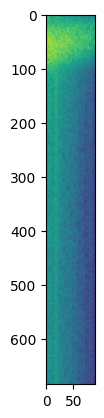

In [12]:
f,t,spgram = sp.signal.spectrogram(line, fs=fs, window=('tukey', 0.25), nperseg=nz, noverlap=nz-wz, nfft=nFFT)
# spgram.shape
plt.imshow(np.log(spgram))
plt.colorbar
plt.show()

In [13]:
rang = np.squeeze((f > freq_L) & (f < freq_H))
Slocal = spgram[rang,:]

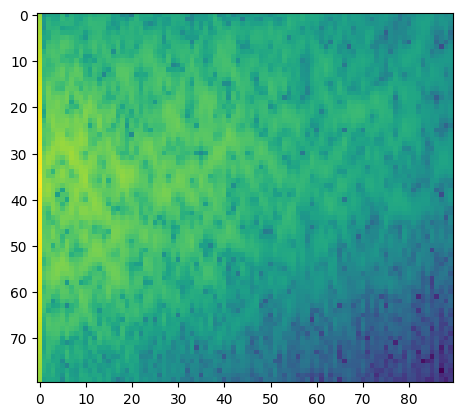

In [14]:
plt.imshow(np.log(Slocal))
plt.show()

## Spectrogram of all lines

In [11]:
f,t,spgram = sp.signal.spectrogram(rf, fs=fs, window=('tukey', 0.25), nperseg=nz, noverlap=nz-wz, nfft=nFFT, axis=0)
spgram.shape

(685, 128, 90)

In [12]:
rang = np.squeeze((f > freq_L) & (f < freq_H))
Slocal = spgram[rang,:,:]
Slocal = np.moveaxis(Slocal, [1, 2], [2, 1])
Slocal[0,:,:].shape

(90, 128)

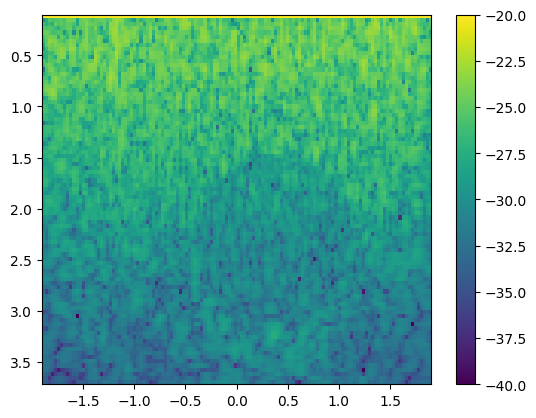

In [46]:

z_ACS = c0*t[:-1]/2 *100
x_ACS = x
extent_ACS = (x_ACS[0], x_ACS[-1], z_ACS[-1], z_ACS[0])


plt.imshow(np.log(Slocal[40,:,:]), extent=extent_ACS)
plt.clim(-40,-20)
plt.colorbar()
plt.show()

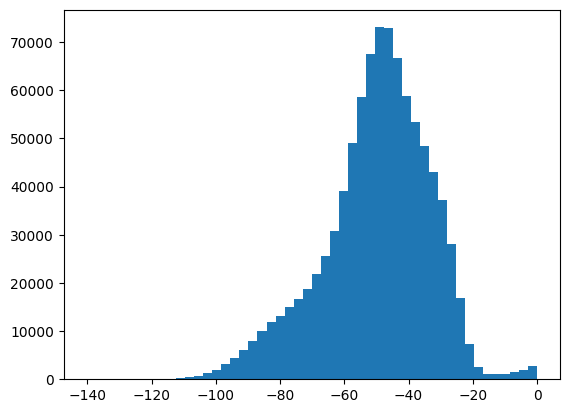

In [18]:
Slocal = Slocal/np.max(Slocal)
plt.hist(10*np.log10(Slocal.flatten()),50)
plt.show()

(80, 89, 128)


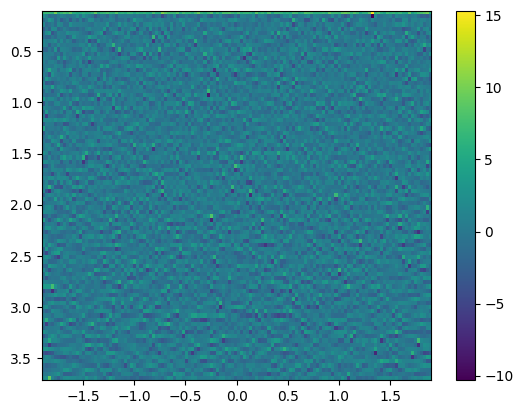

In [19]:
sld = -np.diff(np.log(Slocal), axis=1)
print(sld.shape)
plt.imshow(sld[-1,:,:], extent=extent_ACS)
plt.colorbar()
plt.show()

# Testing functions

In [30]:
def get_sld(rf, fs, freq_L, freq_H, deltaF, blocksize, overlap_pc):
    (z_ACS,Slocal) = get_spectra(rf, fs, freq_L, freq_H, deltaF, blocksize, overlap_pc)
    z_ACS = (z_ACS[:-1] + z_ACS[1:])/2
    sld = -np.diff(np.log(Slocal), axis=1)
    return z_ACS,sld

def get_spectra(rf, fs, freq_L, freq_H, deltaF, blocksize, overlap_pc):
    freq_C = (freq_L+freq_H)/2
    # Wavelength size
    c0 = 1540
    wl = c0/freq_C
    dz = 1/fs*c0/2
    
    nFFT = int((fs/deltaF))
    
    wz = int(blocksize*wl*(1-overlap_pc)/dz ) # Between windows
    nz = 2*int(blocksize*wl/dz /2 ) # Window size

    f,t,spgram = sp.signal.spectrogram(rf, fs=fs, window=('tukey', 0.25), nperseg=nz, noverlap=nz-wz, nfft=nFFT, axis=0)
    rang = np.squeeze((f > freq_L) & (f < freq_H))
    Slocal = spgram[rang,:,:]
    Slocal = np.moveaxis(Slocal, [1, 2], [2, 1])
    Slocal = Slocal[:,1:,:]
    Slocal = Slocal/np.max(Slocal)
    z_ACS = c0*t[1:]/2 *100
    return z_ACS,Slocal

(z_ACS,sld) = get_sld(rf, fs, freq_L, freq_H, deltaF, blocksize, overlap_pc)
(z_ACS,Slocal) = get_spectra(rf, fs, freq_L, freq_H, deltaF, blocksize, overlap_pc)

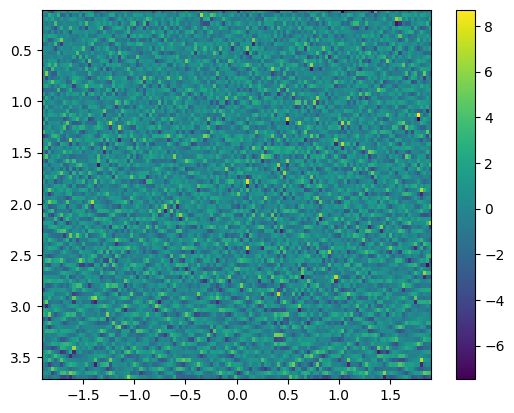

In [31]:
plt.imshow(sld[-1,:,:], extent=extent_ACS)
plt.colorbar()
plt.show()

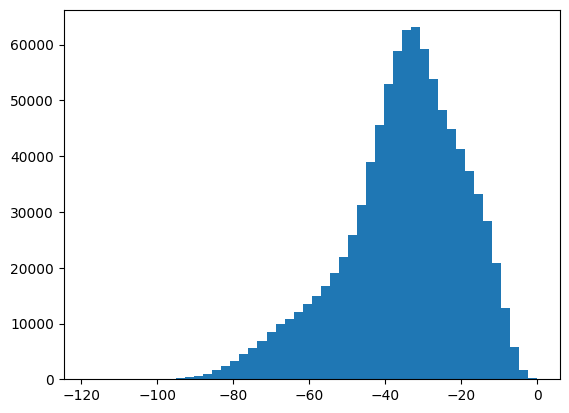

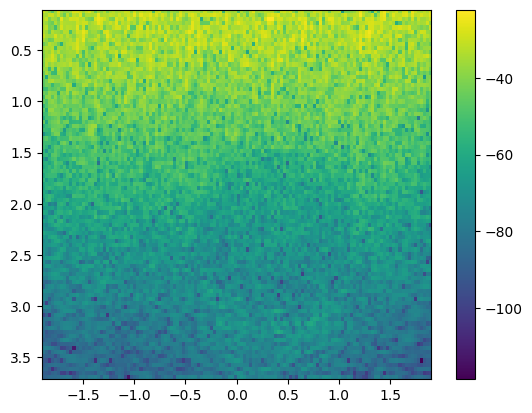

In [34]:
# Slocal.shape
logS = 10*np.log10(Slocal)
plt.hist(logS.flatten(),50)
plt.show()

plt.imshow(logS[-1,:,:], extent=extent_ACS)
plt.colorbar()
plt.show()

In [84]:
alpha_back = data_dict['alpha_mean'][0,0]
alpha_inc = data_dict['alpha_mean'][0,1]
cx = data_dict['center_meters'][0,0]*100 + x_offset
cz = data_dict['center_meters'][0,1]*100
r = data_dict['radius_meters'][0,0]*100

xv, zv = np.meshgrid(x, z_ACS, indexing='xy')
inc = ((xv - cx)**2 + (zv - cz)**2) < r**2

att_ideal = np.ones(xv.shape)*alpha_back
att_ideal[inc] = alpha_inc

# Creating dataset

In [ ]:
# Dataset
import torch
import os
from torchvision import transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import scipy as sp
data_dir = Path(r'C:\Users\sebas\Documents\MATLAB\DataProCiencia\DeepLearning\raw')


In [ ]:
def get_sld(rf, fs, freq_L, freq_H, deltaF, blocksize, overlap_pc):
    freq_C = (freq_L+freq_H)/2
    # Wavelength size
    c0 = 1540
    wl = c0/freq_C
    dz = 1/fs*c0/2
    
    nFFT = int(fs/deltaF)
    
    wz = int(blocksize*wl*(1-overlap_pc)/dz ); # Between windows
    nz = 2*int(blocksize*wl/dz /2 ); # Window size

    f,t,spgram = sp.signal.spectrogram(rf, fs=fs, window=('tukey', 0.25), nperseg=nz, noverlap=nz-wz, nfft=nFFT, axis=0)
    spgram.shape
    rang = np.squeeze((f > freq_L) & (f < freq_H))
    Slocal = spgram[rang,:,:]
    Slocal = np.moveaxis(Slocal, [1, 2], [2, 1])
    Slocal.shape
    z_ACS = c0*t[:-1]/2 *100
    sld = -np.diff(np.log(Slocal), axis=1)
    return z_ACS,sld

class CustomDataset(Dataset):
    def __init__(self, data_folder):
        self.data_folder = data_folder
        self.data_file_list = sorted(os.listdir(data_folder))

    def __len__(self):
        return len(self.data_file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_folder, self.data_file_list[idx])
        data_dict = sp.io.loadmat(file_path)

        x = data_dict['x'].squeeze()
        z = data_dict['z'].squeeze()
        x_offset = x[0]*100
        x = 100*x
        z = 100*z

        rf = data_dict['rf']
        fs = data_dict['fs']
        c0 = data_dict['sos_mean']

        blocksize = 7.5
        freq_L = 2e6; freq_H = 10e6 
        deltaF = 100e3
        overlap_pc      = 0.8
        (z_ACS,sld) = get_sld(rf, fs, freq_L, freq_H, deltaF, blocksize, overlap_pc)


        alpha_back = data_dict['alpha_mean'][0,0]
        alpha_inc = data_dict['alpha_mean'][0,1]
        cx = data_dict['center_meters'][0,0]*100 + x_offset
        cz = data_dict['center_meters'][0,1]*100
        r = data_dict['radius_meters'][0,0]*100

        xv, zv = np.meshgrid(x, z_ACS, indexing='xy')
        inc = ((xv - cx)**2 + (zv - cz)**2) < r**2

        att_ideal = np.ones(xv.shape)*alpha_back
        att_ideal[inc] = alpha_inc

        return torch.Tensor(sld), torch.Tensor(att_ideal).unsqueeze(0)

In [ ]:
dataset = CustomDataset(data_dir)
(x,y) = dataset.__getitem__(5)

In [ ]:
x.shape